<a href="https://colab.research.google.com/github/freedom-780/Psychedelic-mushrooms/blob/main/Psychedelic_mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Import data from github
data = "https://raw.githubusercontent.com/freedom-780/Psychedelic-mushrooms/main/AHRI_DATASET_PM_MANUSCRIPT_DATA.csv"
p_mush_df = pd.read_csv(data)

In [3]:
p_mush_df.shape

(7139, 57)

In [4]:
# copy dataframe for analysis to preserve original dataframe
df = p_mush_df.copy()

In [5]:
# Set index to case ID since every caseID is Unique
df.set_index('CASEID_7139', inplace=True)

In [6]:
df.columns

Index(['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN',
       'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION', 'ED',
       'EMPL', 'INCOME', 'BMI', 'C_TOTAL', 'C_DP', 'C_ANX', 'C_PN', 'C_ALL',
       'C_MI', 'C_INSOM', 'C_HYP', 'C_DH', 'C_SA', 'C_GERD', 'C_CS', 'C_LIP',
       'CCI_SCORE', 'GAD7_SCORE', 'PHQ9_SCORE', 'GAD7_GE10', 'PHQ9_GE10',
       'PCS12', 'MCS12', 'VR6D', 'RU_PCP_YN', 'RU_SPECIAL_YN', 'RU_OTPCP_YN',
       'RU_UCC_YN', 'RU_OUTPT_YN', 'RU_ER_YN', 'RU_HSP_YN',
       'PSY1_POSITIVE_USE', 'PSY2_GEN_HEALTH', 'PSY2_DIAG_CONDITION',
       'PSY2_UNDIAG_CONCERN', 'PSY2_NO_KNOWLEDGE', 'PM1_GEN_HEALTH',
       'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN', 'PM2_FREQ_COVID',
       'PM3_FREQ_POLITICS', 'PM4_CARE', 'INSURANCE', 'DATA_WEIGHT'],
      dtype='object')

In [70]:
df.head().T

CASEID_7139,1,2,3,4,5
PSY_USE_YN,1.00,1.00,1.00,1.00,1.00
SEX,0.00,0.00,0.00,0.00,0.00
AGE,19.00,21.00,22.00,22.00,23.00
ETHNICITY,3.00,2.00,2.00,2.00,2.00
HLS_YN,1.00,0.00,0.00,0.00,0.00
REGION,4.00,2.00,4.00,3.00,2.00
ED,0.00,1.00,0.00,1.00,0.00
EMPL,0.00,0.00,0.00,0.00,1.00
INCOME,"65,847.00","30,585.00","49,259.00","54,135.00","49,425.00"
BMI,27.41,29.26,20.60,18.56,36.80


In [9]:
# make a list of columns to keep

columns_keep = ['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN', 'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION',  \
                 'ED', 'EMPL', 'INCOME', 'BMI', 'GAD7_SCORE', 'PHQ9_SCORE']

This dataset has 57 columns initially, most of these were dropped, trying to predict the PHQ9 score(ranges from 0-27) that has different ranges for different severity of depression. Those rows that were dropped have to do with hostipals stays, previous conditions of the patient, etc. while these might be useful to the model, only the qualities of the patient and psychedelics use is of interest, at least initally, but will try different features, after trying out a simple model and testing.


In [10]:
df.drop(df.columns.difference(columns_keep), 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [11]:
df.sample(5).T

CASEID_7139,4717,2824,1398,4694,3707
COHORTS,0.00,0.00,0.00,0.00,0.00
PYS_USE_VENN,0.00,0.00,0.00,0.00,0.00
PSY_USE_YN,0.00,0.00,0.00,0.00,0.00
PM_USE_YN,0.00,0.00,0.00,0.00,0.00
PM_USE_ONLY_YN,0.00,0.00,0.00,0.00,0.00
PM_VS_PSY_YN,-99.00,-99.00,-99.00,-99.00,-99.00
SEX,1.00,0.00,0.00,1.00,0.00
AGE,36.00,61.00,37.00,35.00,76.00
ETHNICITY,2.00,2.00,2.00,2.00,2.00
HLS_YN,0.00,0.00,0.00,0.00,0.00


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
COHORTS,"7,139.00",-5.59,22.88,-99.00,0.00,0.00,0.00,1.00
PYS_USE_VENN,"7,139.00",0.17,0.64,0.00,0.00,0.00,0.00,3.00
PSY_USE_YN,"7,139.00",0.07,0.26,0.00,0.00,0.00,0.00,1.00
PM_USE_YN,"7,139.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00
PM_USE_ONLY_YN,"7,139.00",0.02,0.13,0.00,0.00,0.00,0.00,1.00
PM_VS_PSY_YN,"7,139.00",-91.60,26.25,-99.00,-99.00,-99.00,-99.00,2.00
SEX,"7,139.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00
AGE,"7,139.00",46.15,16.65,18.00,33.00,43.00,60.00,95.00
ETHNICITY,"7,139.00",1.95,0.51,1.00,2.00,2.00,2.00,3.00
HLS_YN,"7,139.00",0.08,0.27,0.00,0.00,0.00,0.00,1.00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COHORTS         7139 non-null   float64
 1   PYS_USE_VENN    7139 non-null   float64
 2   PSY_USE_YN      7139 non-null   float64
 3   PM_USE_YN       7139 non-null   float64
 4   PM_USE_ONLY_YN  7139 non-null   float64
 5   PM_VS_PSY_YN    7139 non-null   float64
 6   SEX             7139 non-null   int64  
 7   AGE             7139 non-null   float64
 8   ETHNICITY       7139 non-null   float64
 9   HLS_YN          7139 non-null   float64
 10  REGION          7139 non-null   float64
 11  ED              7139 non-null   float64
 12  EMPL            7139 non-null   float64
 13  INCOME          7139 non-null   int64  
 14  BMI             7139 non-null   float64
 15  GAD7_SCORE      7139 non-null   float64
 16  PHQ9_SCORE      7139 non-null   float64
dtypes: float64(15), int64(2)
memory u

there are a few columns that have the wrong **data type** such as **PSY_USE_YN** that should be integers not floats

In [14]:
# make a dataframe of columns to convert to int64
convert_cols = {'COHORTS':'int64',
                'PYS_USE_VENN':'int64',
                'PSY_USE_YN':'int64',
                'PM_USE_YN':'int64',
                'PM_USE_ONLY_YN':'int64',
                'PM_VS_PSY_YN':'int64',
                'SEX':'int64',
                'AGE':'int64',
                'ETHNICITY':'int64',
                'HLS_YN':'int64',
                'REGION':'int64',
                'ED':'int64',
                'EMPL':'int64'
                              
               }

In [15]:
df = df.astype(convert_cols)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COHORTS         7139 non-null   int64  
 1   PYS_USE_VENN    7139 non-null   int64  
 2   PSY_USE_YN      7139 non-null   int64  
 3   PM_USE_YN       7139 non-null   int64  
 4   PM_USE_ONLY_YN  7139 non-null   int64  
 5   PM_VS_PSY_YN    7139 non-null   int64  
 6   SEX             7139 non-null   int64  
 7   AGE             7139 non-null   int64  
 8   ETHNICITY       7139 non-null   int64  
 9   HLS_YN          7139 non-null   int64  
 10  REGION          7139 non-null   int64  
 11  ED              7139 non-null   int64  
 12  EMPL            7139 non-null   int64  
 13  INCOME          7139 non-null   int64  
 14  BMI             7139 non-null   float64
 15  GAD7_SCORE      7139 non-null   float64
 16  PHQ9_SCORE      7139 non-null   float64
dtypes: float64(3), int64(14)
memory u

looks like the columns are the correct data types now 

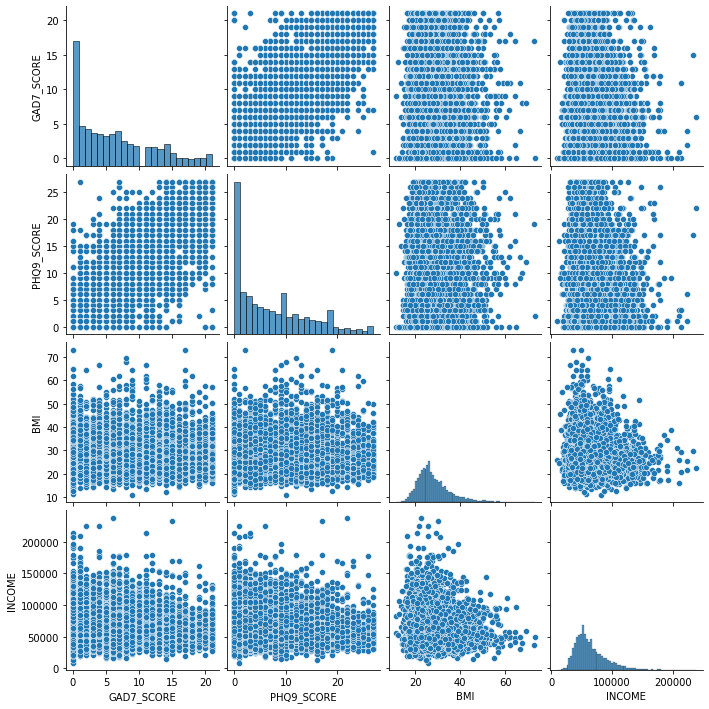

In [17]:
sns.pairplot(df[['GAD7_SCORE','PHQ9_SCORE', 'BMI', 'INCOME']]);

looks like PHQ9_SCORE(Depression Score) and GAD7_Score(Anxiety) and positively correlated, would be better for the model if one of these were dropped, the interest for this analysis is in the PHQ9 score, which is more of a sevre indicator

In [18]:
df = df.drop('GAD7_SCORE', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   COHORTS         7139 non-null   int64  
 1   PYS_USE_VENN    7139 non-null   int64  
 2   PSY_USE_YN      7139 non-null   int64  
 3   PM_USE_YN       7139 non-null   int64  
 4   PM_USE_ONLY_YN  7139 non-null   int64  
 5   PM_VS_PSY_YN    7139 non-null   int64  
 6   SEX             7139 non-null   int64  
 7   AGE             7139 non-null   int64  
 8   ETHNICITY       7139 non-null   int64  
 9   HLS_YN          7139 non-null   int64  
 10  REGION          7139 non-null   int64  
 11  ED              7139 non-null   int64  
 12  EMPL            7139 non-null   int64  
 13  INCOME          7139 non-null   int64  
 14  BMI             7139 non-null   float64
 15  PHQ9_SCORE      7139 non-null   float64
dtypes: float64(2), int64(14)
memory usage: 1.2 MB


In [19]:
df['COHORTS'].value_counts()

 0     6613
-99     404
 1      122
Name: COHORTS, dtype: int64

In [20]:
df['PM_USE_ONLY_YN'].value_counts()

0    7017
1     122
Name: PM_USE_ONLY_YN, dtype: int64

In [21]:
df['PM_VS_PSY_YN'].value_counts()

-99    6613
 1      270
 2      256
Name: PM_VS_PSY_YN, dtype: int64

In [22]:
df['PSY_USE_YN'].value_counts()

0    6613
1     526
Name: PSY_USE_YN, dtype: int64

In [23]:
df['PYS_USE_VENN'].value_counts()

0    6613
3     270
2     134
1     122
Name: PYS_USE_VENN, dtype: int64

In [24]:
df['PM_USE_YN'].value_counts()

0    6883
1     256
Name: PM_USE_YN, dtype: int64

In [25]:
df['PM_USE_ONLY_YN'].value_counts()

0    7017
1     122
Name: PM_USE_ONLY_YN, dtype: int64

The dataset seems to be unbalanced with more 0 than 1s if we were going to classify psychedelics use. Even though predicting psychedelic use based on the other features, a more interesting question is predicting the depression score based on the other features. This way you can have some idea of their beanift

Would like to use **PM_USE_ONLY_YN** or **PSY_USE_YN** the **PSY_USE_YN**(which is psychedelics used as a 1 or 0 otherwise) yet different psychedelics have different effects on mind based on research, but it's a good start for a simplified model

In [26]:
df.drop(['COHORTS',  'PYS_USE_VENN', 'PM_USE_YN',  'PM_USE_ONLY_YN','PM_VS_PSY_YN'], axis=1, \
       inplace=True)

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PSY_USE_YN,"7,139.00",0.07,0.26,0.00,0.00,0.00,0.00,1.00
SEX,"7,139.00",0.46,0.50,0.00,0.00,0.00,1.00,1.00
AGE,"7,139.00",46.15,16.65,18.00,33.00,43.00,60.00,95.00
ETHNICITY,"7,139.00",1.95,0.51,1.00,2.00,2.00,2.00,3.00
HLS_YN,"7,139.00",0.08,0.27,0.00,0.00,0.00,0.00,1.00
REGION,"7,139.00",2.63,1.00,1.00,2.00,3.00,3.00,4.00
ED,"7,139.00",0.73,0.45,0.00,0.00,1.00,1.00,1.00
EMPL,"7,139.00",0.30,0.46,0.00,0.00,0.00,1.00,1.00
INCOME,"7,139.00","64,563.71","26,258.63","9,076.00","46,322.50","58,129.00","77,263.00","237,841.00"
BMI,"7,139.00",28.02,7.25,11.16,23.05,26.58,31.41,73.12


In [28]:

print(f"Shape data: {df.shape}")
print(f"Number of mission values in data: \
{df.isnull().sum().sum()}")
print(f"Number of duplicate values in data: \
{df.duplicated().sum()}")

Shape data: (7139, 11)
Number of mission values in data: 0
Number of duplicate values in data: 3


In [29]:
df.nunique()

PSY_USE_YN       2
SEX              2
AGE             76
ETHNICITY        3
HLS_YN           2
REGION           4
ED               2
EMPL             2
INCOME        4890
BMI           1551
PHQ9_SCORE      28
dtype: int64

<Figure size 1080x1080 with 0 Axes>

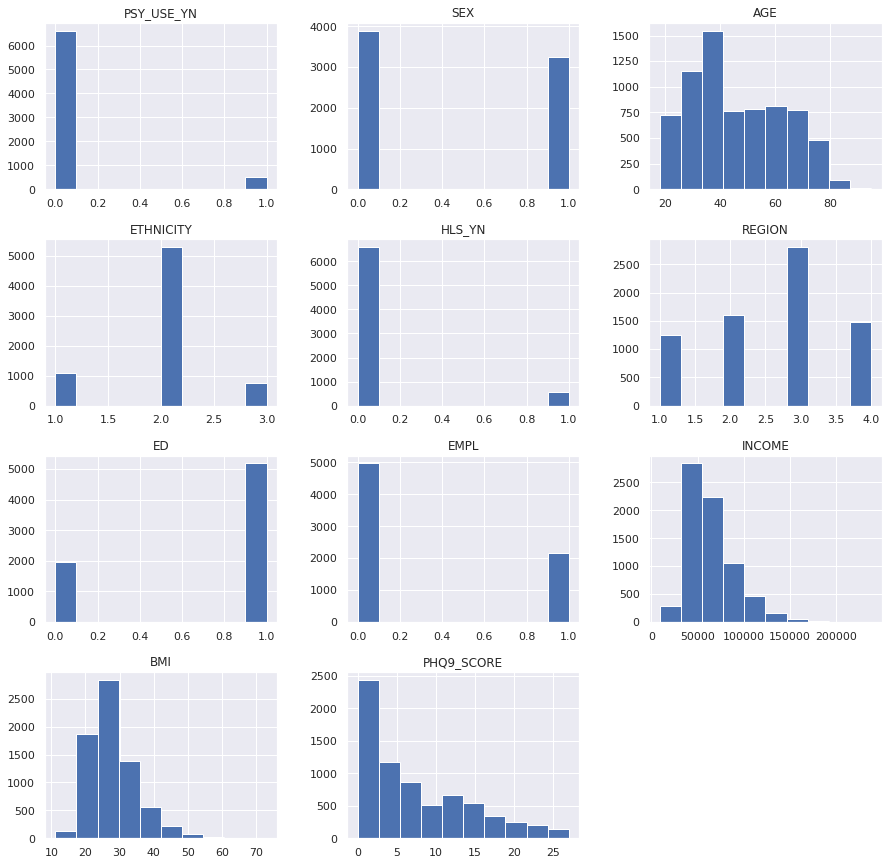

In [30]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.tight_layout()
df.hist();

Most of the data seems to be shewed with left tails, may need to do transformations on the data such as standardization 

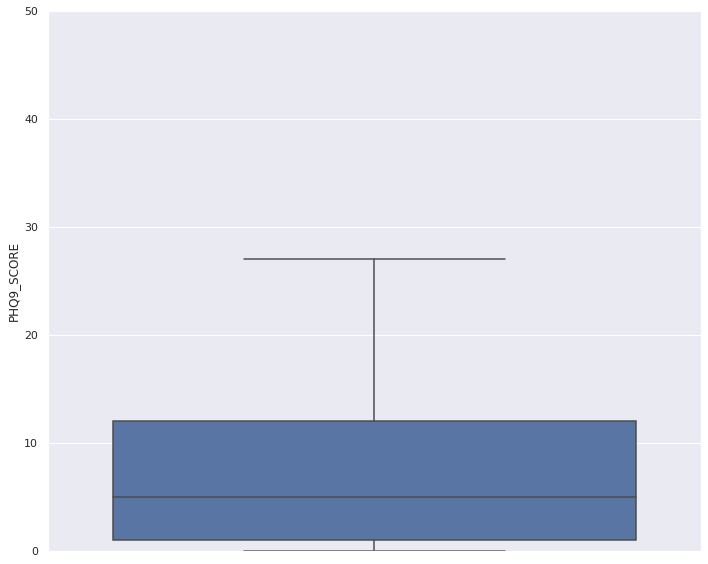

In [31]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.boxplot(y ='PHQ9_SCORE',data=df)
plt.ylim(0, 50)
plt.tight_layout()

seems there are no outliers for the dependent vaiable

In [32]:
df['PHQ9_SCORE'].describe()

count   7,139.00
mean        7.33
std         6.99
min         0.00
25%         1.00
50%         5.00
75%        12.00
max        27.00
Name: PHQ9_SCORE, dtype: float64

**PHQ9_SCORE** has a range of 0-27, and several increasing depression categories and needs to be remapped 

In [33]:
# define function to use with apply and lambda to remap PHQ9_SCORE column

def PHQ9_remap_1(x):
    if (x >= 0) & (x <= 4):
        x = 1
    elif (x >= 5) & (x <= 9):
        x = 2
    elif (x >= 10) & (x <= 14):
        x = 3
    elif (x >= 15) & (x <= 19):
        x = 4 
    else:
        x = 5

    return x 

    
    



In [34]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_1(x['PHQ9_SCORE']), axis=1)

In [35]:
df['PHQ9_SCORE']

CASEID_7139
1       2
2       1
3       4
4       4
5       4
       ..
7135    3
7136    1
7137    1
7138    1
7139    1
Name: PHQ9_SCORE, Length: 7139, dtype: int64

In [36]:
df['PHQ9_SCORE'].value_counts()

1    3286
2    1490
3    1097
4     774
5     492
Name: PHQ9_SCORE, dtype: int64

We can see that the PHQ9 score is unbalanced, but thinking about this from a health prespective, those that are > category 1(minimal depression) don't need any type of help or action, so we will remap this into 0 needing no action and 1 needing action.

In [37]:
def PHQ9_remap_2 (x):
  if x == 1:
    x = 0
  else: 
    x = 1
  return x 

In [38]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_2(x['PHQ9_SCORE']), axis=1)

In [39]:
df['PHQ9_SCORE'].sample(10)

CASEID_7139
6744    1
5719    0
5438    0
2818    1
2523    1
6475    0
5150    1
6922    1
4460    1
3296    0
Name: PHQ9_SCORE, dtype: int64

In [58]:
df['PHQ9_SCORE'].value_counts()

1    3853
0    3286
Name: PHQ9_SCORE, dtype: int64

In [59]:
df['PSY_USE_YN'].value_counts()

0    6613
1     526
Name: PSY_USE_YN, dtype: int64

0.9263202129149741

looks like the 'PSY_USE_YN' column is unbalanced 

In [40]:
df.head()

,PSY_USE_YN,SEX,AGE,ETHNICITY,HLS_YN,REGION,ED,EMPL,INCOME,BMI,PHQ9_SCORE
CASEID_7139,,,,,,,,,,,
1,1,0,19,3,1,4,0,0,65847,27.41,1
2,1,0,21,2,0,2,1,0,30585,29.26,0
3,1,0,22,2,0,4,0,0,49259,20.60,1
4,1,0,22,2,0,3,1,0,54135,18.56,1
5,1,0,23,2,0,2,0,1,49425,36.80,1


the dataframe is properly cleaned and encoded now, now we need to split the data into train/test sets and scale the continous data features

In [41]:
df_clean = df 

In [42]:
df_clean.sample(5)

,PSY_USE_YN,SEX,AGE,ETHNICITY,HLS_YN,REGION,ED,EMPL,INCOME,BMI,PHQ9_SCORE
CASEID_7139,,,,,,,,,,,
5712,0,1,52,3,0,1,1,1,147109,21.92,1
4536,0,1,34,2,0,2,0,0,58903,27.26,1
6911,1,1,28,2,0,3,0,0,45057,21.28,1
4838,0,1,37,2,0,4,1,1,96355,64.91,0
4983,0,1,39,2,0,4,1,1,156856,16.05,1


In [43]:
X, y = df_clean.loc[:, 'PSY_USE_YN': 'BMI'].values, df_clean.loc[:, 'PHQ9_SCORE'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 0, \
                                                   stratify = y)

In [51]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())

In [52]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.666


In [56]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y
                         =y_train, cv=20, n_jobs=2)

print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.672      0.62       0.636      0.632      0.696      0.672
 0.644      0.604      0.7        0.652      0.7        0.656
 0.672      0.648      0.672      0.66       0.604      0.65863454
 0.65461847 0.63052209]


In [68]:
pipe_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=25, random_state=0))

In [69]:
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.666


This current model has high bias, and we should try including more features in the model 